Import libraries

In [1]:
import os 
import pickle
import random
import numpy as np
from tqdm import tqdm
from pprint import pprint 
from molmass import Formula
import rdkit.Chem as Chem
from msbuddy.utils import read_formula_str

import pandas as pd
from scipy.stats import pearsonr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matchms import Spectrum
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.importing import load_from_msp
from matchms.filtering import select_by_intensity

In [2]:
data_path = "/data/rbg/users/klingmin/projects/MS_processing/data/final/MS_merged_w_mol_annotations.msp"
data = [s for s in tqdm(load_from_msp(data_path))]
plots_folder = "./plots"

223757it [04:34, 814.61it/s] 


In [7]:
greedy_cs = CosineGreedy()

Helper functions

In [8]:
def unpack_get_mean_score(scores):

    scores = scores.to_array()
    shape = scores.shape
    avg_score = [] 

    for i in range(shape[0]):
        for j in range(shape[1]):
            
            avg_score.append(scores[i,j][0])

    return np.mean(avg_score)

Check how well can we lookup MS across instruments

In [9]:
data_repeated = {} 

for spec in data: 

    metadata = spec.metadata

    energy = float(metadata["collision_energy"])
    inchikey = metadata["inchikey"][:14]
    instrument = metadata["instrument_type"]

    adduct = metadata["adduct"]
    if adduct != "[M+H]+": continue 

    if energy not in data_repeated: data_repeated[energy] = {} 
    if inchikey not in data_repeated[energy]: data_repeated[energy][inchikey] = {} 
    if instrument not in data_repeated[energy][inchikey]: data_repeated[energy][inchikey][instrument] = [] 

    data_repeated[energy][inchikey][instrument].append(spec)

In [10]:
data_repeated_sieved = {}

for energy, rec in data_repeated.items(): 

    if energy not in data_repeated_sieved: data_repeated_sieved[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        counts = sum([len(r) for _, r in rec_2.items()])

        if counts > 1 and len(rec_2.keys()) > 1:
             
             if inchikey not in data_repeated_sieved[energy]: data_repeated_sieved[energy][inchikey] = {}
             
             for instrument, spec in rec_2.items():
                    
                    data_repeated_sieved[energy][inchikey][instrument] = spec

Plot the MS

In [40]:
chosen_rec = data_repeated_sieved[30.0]["QNAYBMKLOCPYGJ"]
chosen_rec

{'LC-ESI-QFT': [Spectrum(precursor m/z=90.06, 7 fragments between 51.3 and 100.7),
  Spectrum(precursor m/z=90.06, 7 fragments between 51.0 and 94.9),
  Spectrum(precursor m/z=90.06, 6 fragments between 68.5 and 103.2),
  Spectrum(precursor m/z=90.06, 83 fragments between 49.5 and 111.1),
  Spectrum(precursor m/z=90.06, 27 fragments between 49.5 and 111.1)],
 'ESI-ITFT': [Spectrum(precursor m/z=90.06, 65 fragments between 51.8 and 106.9)]}

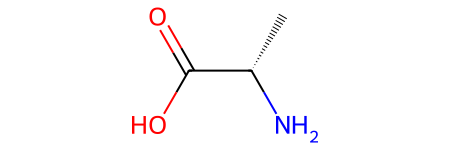

In [42]:
Chem.MolFromSmiles(chosen_rec["LC-ESI-QFT"][0].metadata["smiles"])

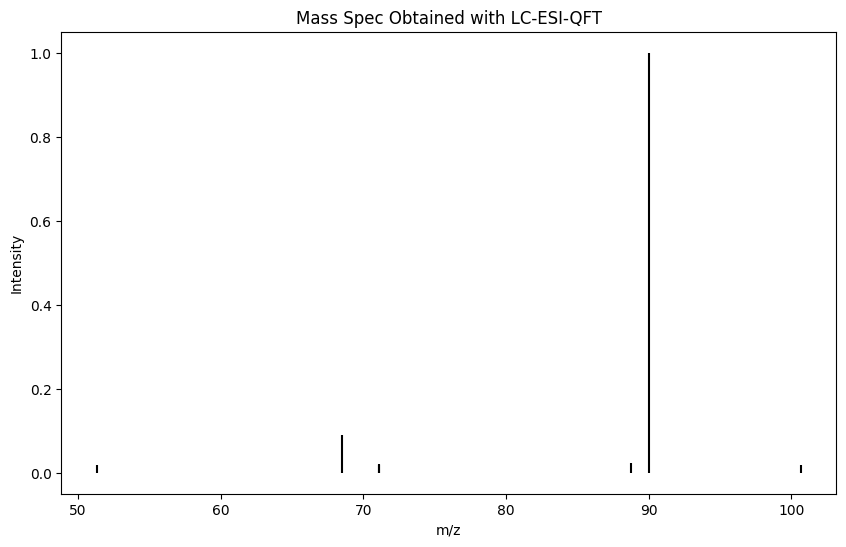

In [50]:
# Create the plot
plt.figure(figsize=(10, 6))
mz_values = chosen_rec["LC-ESI-QFT"][0].mz
intensity_values = chosen_rec["LC-ESI-QFT"][0].intensities
plt.stem(mz_values, intensity_values, linefmt='k-', markerfmt=' ', basefmt=" ", use_line_collection=True)


# Label the axes
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spec Obtained with LC-ESI-QFT')

# Show the plot
plt.savefig(os.path.join(plots_folder, "MS_LC-ESI-QFT.png"))
plt.show()

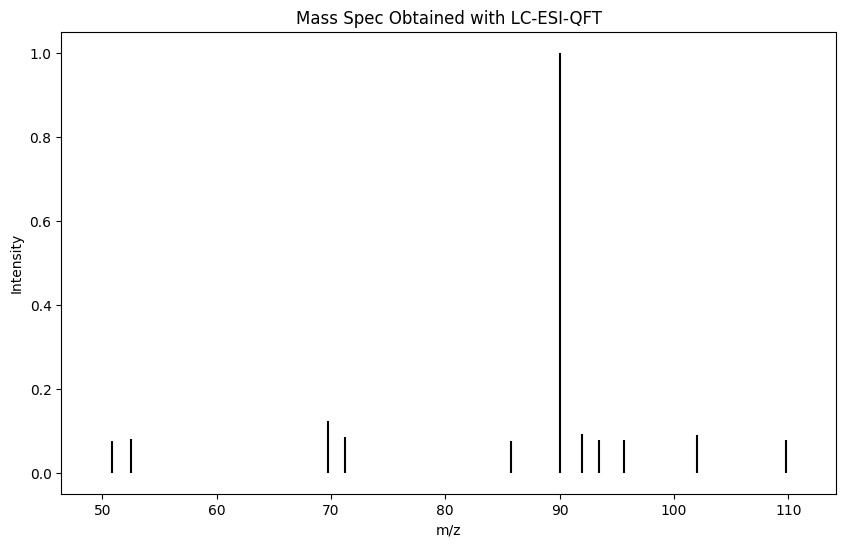

In [53]:
# Create the plot
plt.figure(figsize=(10, 6))
mz_values = chosen_rec["LC-ESI-QFT"][3].mz
intensity_values = chosen_rec["LC-ESI-QFT"][3].intensities
plt.stem(mz_values, intensity_values, linefmt='k-', markerfmt=' ', basefmt=" ", use_line_collection=True)


# Label the axes
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spec Obtained with LC-ESI-QFT')

# Show the plot
plt.savefig(os.path.join(plots_folder, "MS_LC-ESI-QFT_3.png"))
plt.show()

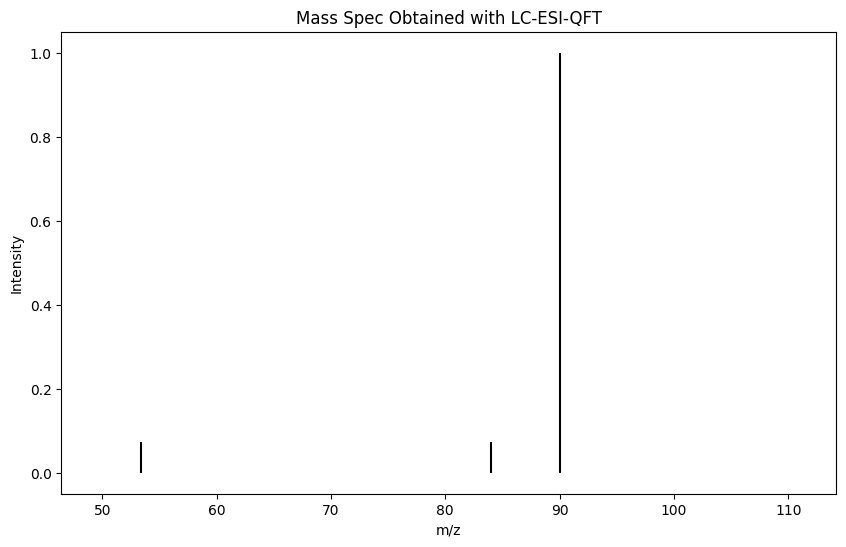

In [54]:
# Create the plot
plt.figure(figsize=(10, 6))
mz_values = chosen_rec["LC-ESI-QFT"][4].mz
intensity_values = chosen_rec["LC-ESI-QFT"][4].intensities
plt.stem(mz_values, intensity_values, linefmt='k-', markerfmt=' ', basefmt=" ", use_line_collection=True)


# Label the axes
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spec Obtained with LC-ESI-QFT')

# Show the plot
plt.savefig(os.path.join(plots_folder, "MS_LC-ESI-QFT_4.png"))
plt.show()

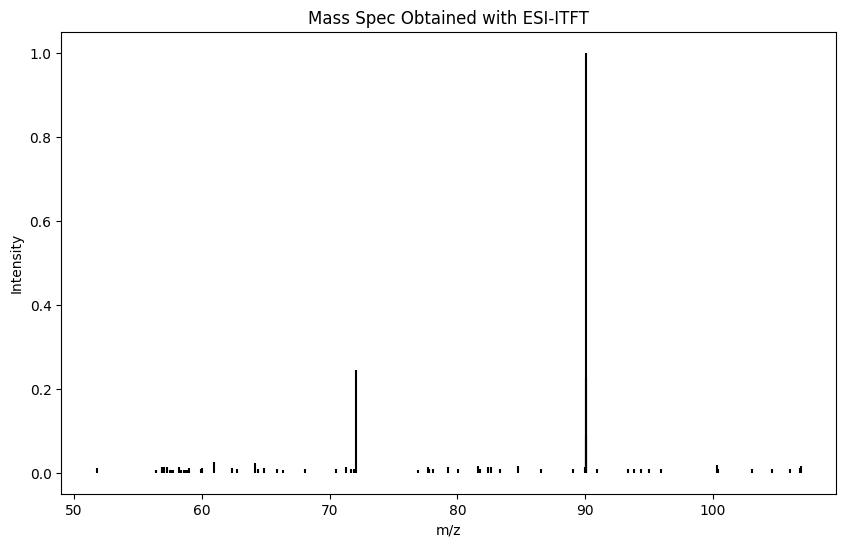

In [51]:
# Create the plot
plt.figure(figsize=(10, 6))
mz_values = chosen_rec["ESI-ITFT"][0].mz
intensity_values = chosen_rec["ESI-ITFT"][0].intensities
plt.stem(mz_values, intensity_values, linefmt='k-', markerfmt=' ', basefmt=" ", use_line_collection=True)

# Label the axes
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Mass Spec Obtained with ESI-ITFT')

# Show the plot
plt.savefig(os.path.join(plots_folder, "MS_ESI-ITFT.png"))
plt.show()

Get similarity of MS across different instruments and same instrument

  0%|          | 0/791 [00:00<?, ?it/s]

 15%|█▌        | 119/791 [00:00<00:02, 268.98it/s]

arrays used as indices must be of integer (or boolean) type


100%|██████████| 791/791 [00:02<00:00, 280.19it/s]


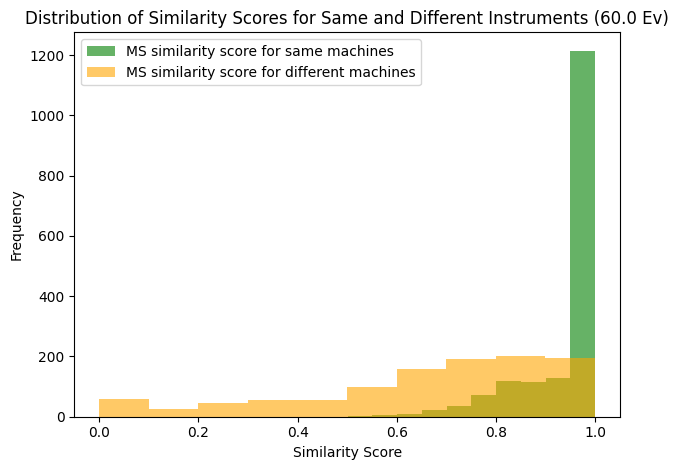

  5%|▌         | 42/776 [00:00<00:05, 136.84it/s]

arrays used as indices must be of integer (or boolean) type


  7%|▋         | 58/776 [00:00<00:06, 110.23it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 14%|█▍        | 107/776 [00:01<00:11, 58.03it/s]

arrays used as indices must be of integer (or boolean) type


 17%|█▋        | 132/776 [00:01<00:09, 66.54it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 20%|█▉        | 154/776 [00:02<00:08, 75.61it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 25%|██▌       | 196/776 [00:02<00:05, 108.40it/s]

arrays used as indices must be of integer (or boolean) type


 29%|██▉       | 227/776 [00:02<00:04, 129.65it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 34%|███▎      | 261/776 [00:02<00:03, 145.75it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 37%|███▋      | 290/776 [00:03<00:03, 124.78it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 46%|████▌     | 355/776 [00:03<00:02, 175.66it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 58%|█████▊    | 451/776 [00:03<00:01, 184.02it/s]

arrays used as indices must be of integer (or boolean) type


 79%|███████▉  | 615/776 [00:04<00:00, 234.90it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 776/776 [00:05<00:00, 145.40it/s]


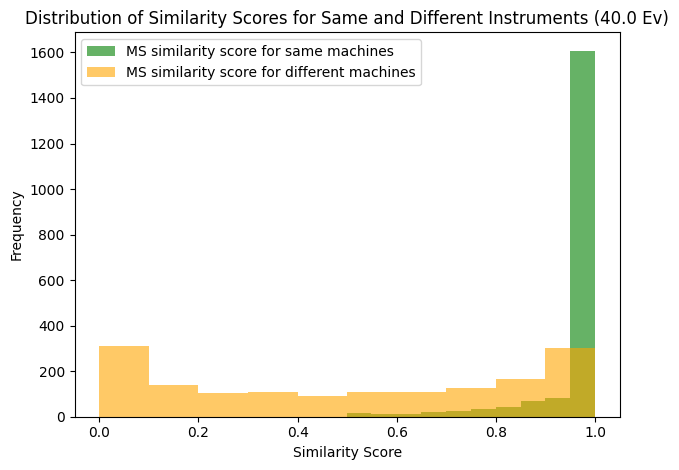

  3%|▎         | 27/774 [00:00<00:02, 249.24it/s]

arrays used as indices must be of integer (or boolean) type


 18%|█▊        | 143/774 [00:00<00:04, 155.73it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 36%|███▌      | 279/774 [00:01<00:02, 237.73it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 59%|█████▉    | 459/774 [00:01<00:00, 345.41it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 64%|██████▍   | 494/774 [00:02<00:01, 268.41it/s]

arrays used as indices must be of integer (or boolean) type


 71%|███████▏  | 553/774 [00:02<00:00, 269.34it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 89%|████████▉ | 687/774 [00:02<00:00, 298.39it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 774/774 [00:03<00:00, 252.58it/s]


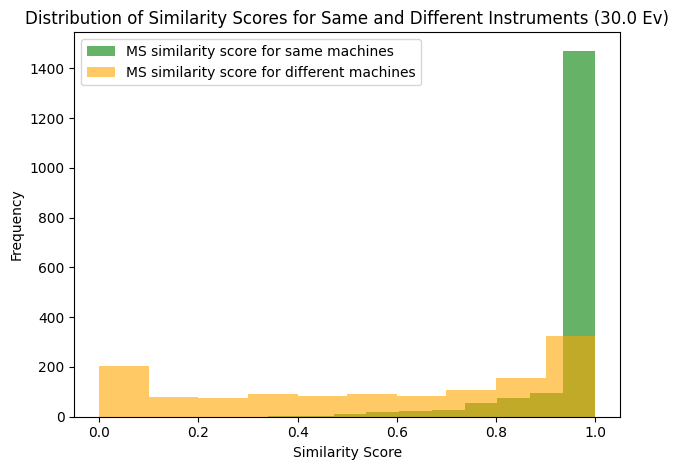

  6%|▋         | 54/833 [00:00<00:03, 254.49it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 13%|█▎        | 109/833 [00:00<00:02, 242.88it/s]

arrays used as indices must be of integer (or boolean) type


 28%|██▊       | 235/833 [00:00<00:01, 367.71it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 40%|███▉      | 331/833 [00:00<00:01, 419.39it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 60%|██████    | 501/833 [00:01<00:00, 453.40it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 84%|████████▍ | 703/833 [00:01<00:00, 581.00it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 833/833 [00:01<00:00, 480.50it/s]


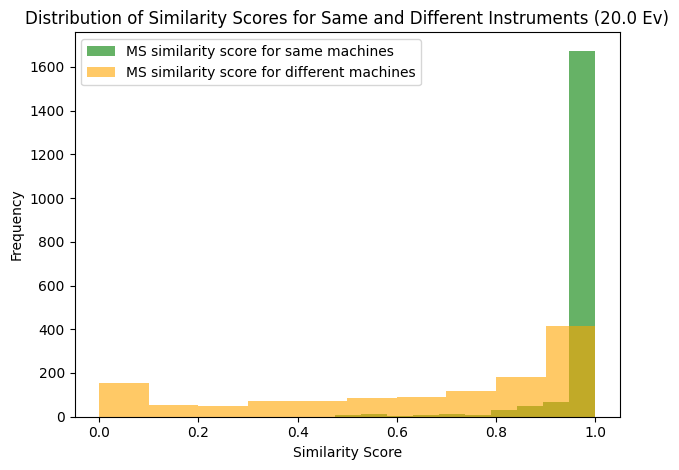

In [63]:
energies = [energy for energy, rec in data_repeated_sieved.items() if len(rec) >= 500]

same_instrument_similarity_all_energy = []
diff_instrument_similarity_all_energy = []

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_get_mean_score(score)

                    if i == j: 
                        same_instrument_similarity.append(score)
                    else:
                        diff_instrument_similarity.append(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    same_instrument_similarity_all_energy.extend(same_instrument_similarity_all)
    diff_instrument_similarity_all_energy.extend(diff_instrument_similarity_all)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores for Same and Different Instruments ({energy} Ev)')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev.png"),bbox_inches='tight')
    plt.show()

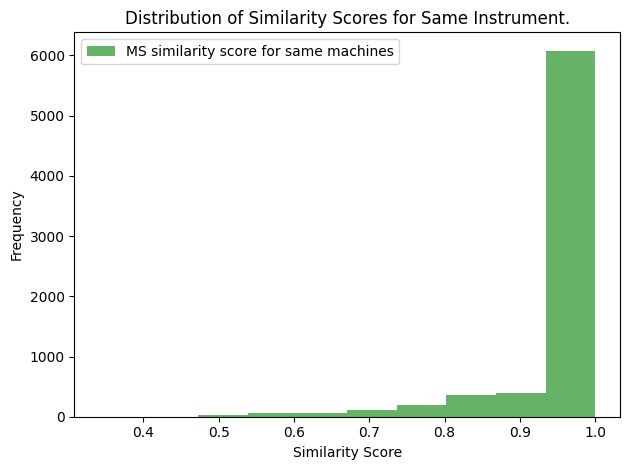

In [55]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(same_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
# axs.hist(diff_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

# Add labels and title
axs.set_xlabel('Similarity Score')
axs.set_ylabel('Frequency')
axs.set_title(f'Distribution of Similarity Scores for Same Instrument.')
axs.legend()  # Display the legend to distinguish the distributions
plt.savefig(os.path.join(plots_folder, f"similarity_same_machine_merged.png"))
plt.show()

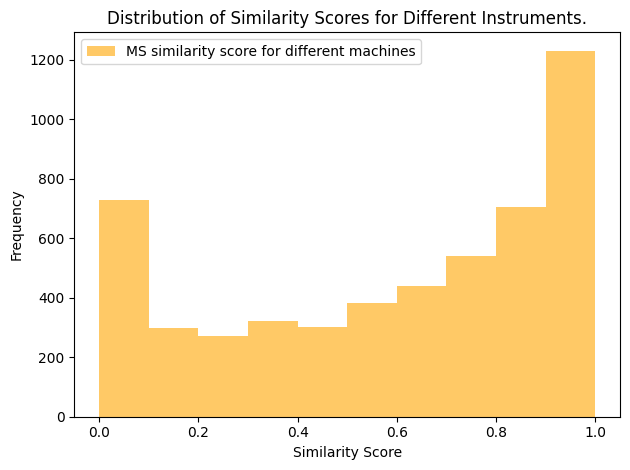

In [56]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
# axs.hist(same_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
axs.hist(diff_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

# Add labels and title
axs.set_xlabel('Similarity Score')
axs.set_ylabel('Frequency')
axs.set_title(f'Distribution of Similarity Scores for Different Instruments.')
axs.legend()  # Display the legend to distinguish the distributions
plt.savefig(os.path.join(plots_folder, f"similarity_different_machines_merged.png"))
plt.show()

Check if the similarity score can be improved by removing low intensity peaks

In [58]:
data_repeated_sieved_remove_peaks_005 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_005: data_repeated_sieved_remove_peaks_005[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_005[energy]: data_repeated_sieved_remove_peaks_005[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.05) for s in spec]
            data_repeated_sieved_remove_peaks_005[energy][inchikey][instrument] = spec_list


data_repeated_sieved_remove_peaks_010 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_010: data_repeated_sieved_remove_peaks_010[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_010[energy]: data_repeated_sieved_remove_peaks_010[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.10) for s in spec]
            data_repeated_sieved_remove_peaks_010[energy][inchikey][instrument] = spec_list


data_repeated_sieved_remove_peaks_015 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_015: data_repeated_sieved_remove_peaks_015[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_015[energy]: data_repeated_sieved_remove_peaks_015[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.15) for s in spec]
            data_repeated_sieved_remove_peaks_015[energy][inchikey][instrument] = spec_list


 17%|█▋        | 137/791 [00:00<00:01, 486.67it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 78%|███████▊  | 617/791 [00:01<00:00, 577.65it/s]

arrays used as indices must be of integer (or boolean) type


100%|██████████| 791/791 [00:01<00:00, 544.64it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


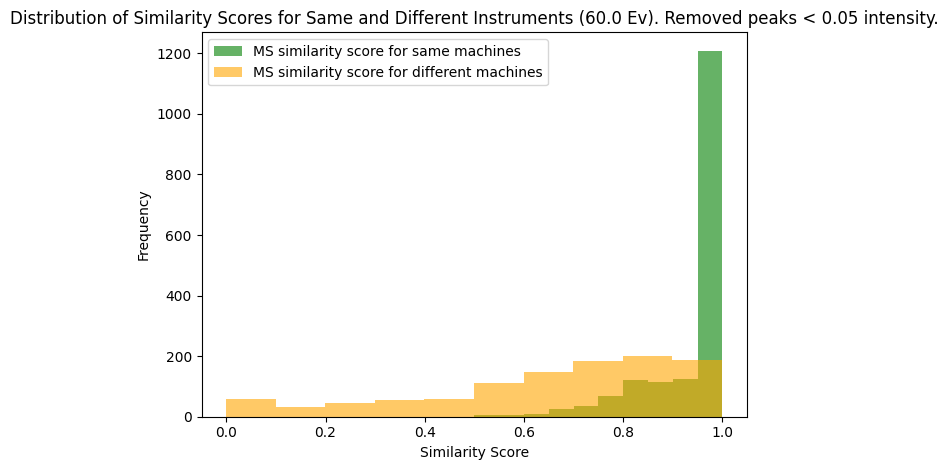

  6%|▌         | 48/776 [00:00<00:04, 181.19it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 11%|█         | 83/776 [00:00<00:05, 123.26it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 15%|█▍        | 115/776 [00:00<00:06, 103.46it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 18%|█▊        | 140/776 [00:01<00:06, 97.80it/s] 

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 25%|██▌       | 196/776 [00:01<00:03, 145.59it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 30%|███       | 236/776 [00:01<00:03, 167.98it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 34%|███▍      | 264/776 [00:01<00:02, 197.22it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 41%|████      | 316/776 [00:02<00:02, 214.67it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 51%|█████     | 393/776 [00:02<00:01, 291.32it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 74%|███████▎  | 571/776 [00:02<00:00, 491.79it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 80%|████████  | 623/776 [00:02<00:00, 376.35it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 86%|████████▌ | 667/776 [00:03<00:00, 308.04it/s]

arrays used as indices must be of integer (or boolean) type


 91%|█████████ | 704/776 [00:03<00:00, 315.17it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 776/776 [00:03<00:00, 226.36it/s]


arrays used as indices must be of integer (or boolean) type


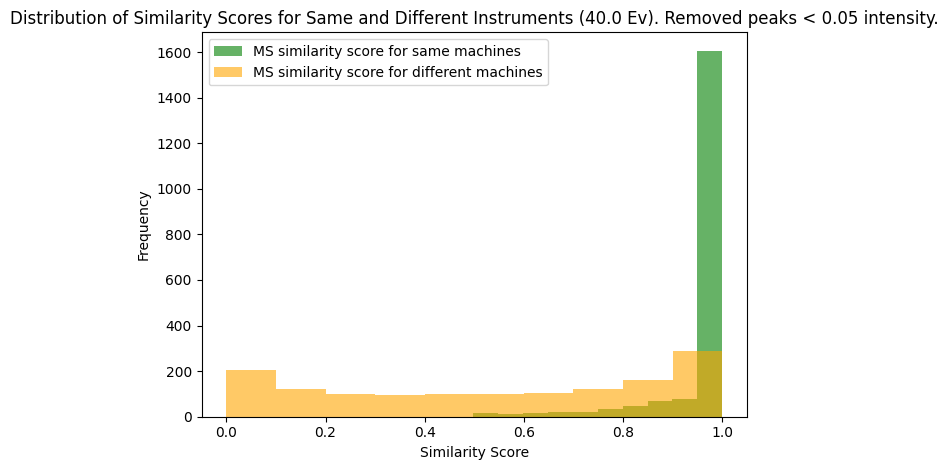

  4%|▎         | 29/774 [00:00<00:02, 276.30it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 14%|█▍        | 110/774 [00:00<00:02, 234.95it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 17%|█▋        | 134/774 [00:00<00:03, 206.27it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 25%|██▌       | 194/774 [00:00<00:02, 228.25it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 33%|███▎      | 257/774 [00:01<00:01, 268.22it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 44%|████▍     | 343/774 [00:01<00:01, 353.20it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 57%|█████▋    | 442/774 [00:01<00:00, 418.22it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 68%|██████▊   | 524/774 [00:01<00:00, 372.98it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 83%|████████▎ | 641/774 [00:02<00:00, 374.90it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 774/774 [00:02<00:00, 333.24it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


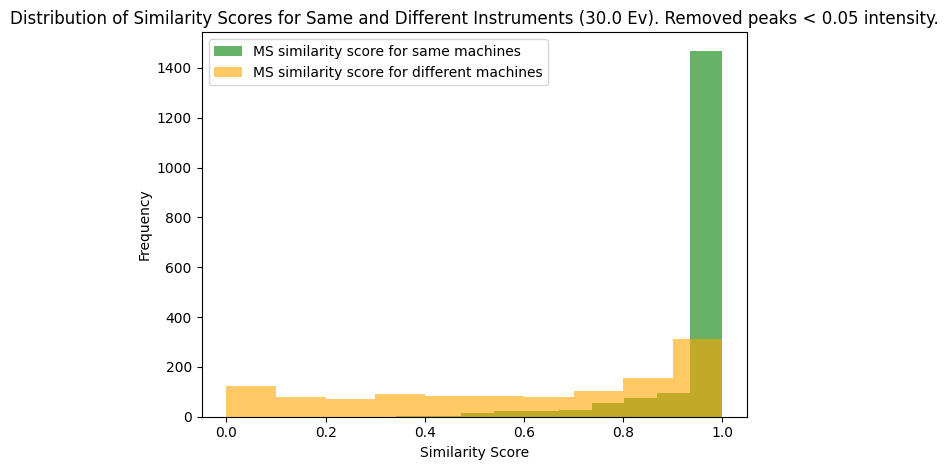

  7%|▋         | 60/833 [00:00<00:02, 294.35it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 17%|█▋        | 143/833 [00:00<00:01, 356.17it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 36%|███▋      | 304/833 [00:00<00:00, 605.66it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 53%|█████▎    | 442/833 [00:00<00:00, 632.79it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 81%|████████  | 675/833 [00:01<00:00, 700.53it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 833/833 [00:01<00:00, 647.81it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


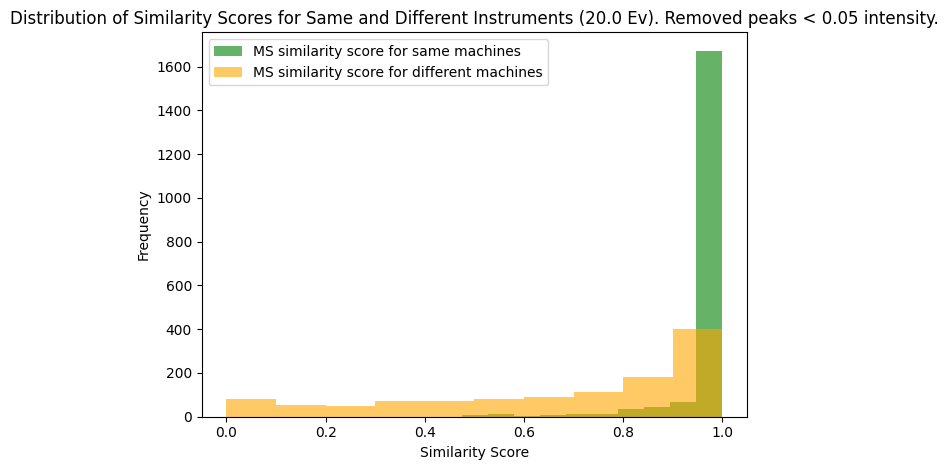

In [60]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_005.items() if len(rec) >= 500] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_005[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_get_mean_score(score)

                    if i == j: 
                        same_instrument_similarity.append(score)
                    else:
                        diff_instrument_similarity.append(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores for Same and Different Instruments ({energy} Ev). Removed peaks < 0.05 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_005.png"), bbox_inches='tight')
    plt.show()

 13%|█▎        | 105/791 [00:00<00:01, 537.55it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 38%|███▊      | 300/791 [00:00<00:00, 594.17it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 69%|██████▉   | 544/791 [00:00<00:00, 553.11it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 791/791 [00:01<00:00, 607.72it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


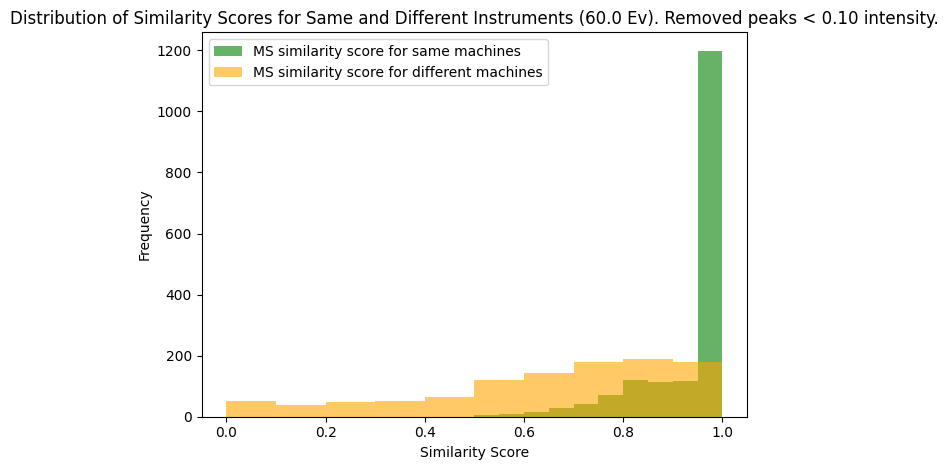

  3%|▎         | 27/776 [00:00<00:02, 263.47it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


  7%|▋         | 54/776 [00:00<00:03, 188.85it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 10%|▉         | 75/776 [00:00<00:04, 145.45it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 13%|█▎        | 104/776 [00:00<00:06, 96.06it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 16%|█▌        | 121/776 [00:01<00:06, 108.75it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 20%|█▉        | 153/776 [00:01<00:05, 107.19it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 25%|██▌       | 196/776 [00:01<00:04, 143.72it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 31%|███       | 242/776 [00:01<00:02, 182.84it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 38%|███▊      | 294/776 [00:02<00:02, 199.65it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 51%|█████▏    | 399/776 [00:02<00:01, 282.12it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 61%|██████▏   | 477/776 [00:02<00:00, 322.02it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 74%|███████▎  | 571/776 [00:02<00:00, 498.18it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 80%|████████  | 622/776 [00:02<00:00, 384.29it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 95%|█████████▌| 741/776 [00:03<00:00, 329.20it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 776/776 [00:03<00:00, 233.46it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


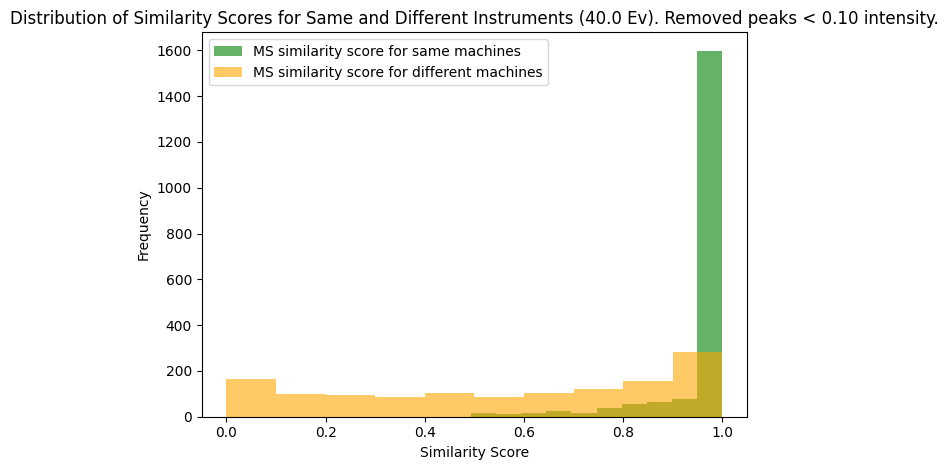

  4%|▎         | 29/774 [00:00<00:02, 288.47it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 11%|█         | 86/774 [00:00<00:02, 267.62it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 18%|█▊        | 138/774 [00:00<00:02, 227.20it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 26%|██▌       | 200/774 [00:00<00:02, 255.07it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 36%|███▌      | 275/774 [00:00<00:01, 315.14it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 48%|████▊     | 374/774 [00:01<00:00, 416.04it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 62%|██████▏   | 478/774 [00:01<00:00, 414.49it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 73%|███████▎  | 563/774 [00:01<00:00, 409.84it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 84%|████████▎ | 647/774 [00:01<00:00, 394.76it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 774/774 [00:02<00:00, 364.53it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


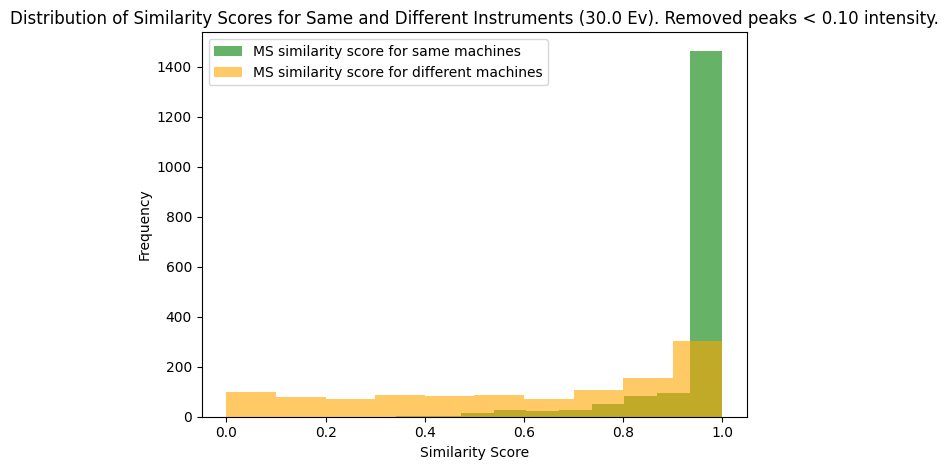

 11%|█▏        | 95/833 [00:00<00:01, 471.43it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 27%|██▋       | 227/833 [00:00<00:01, 587.02it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 39%|███▊      | 321/833 [00:00<00:00, 696.94it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 65%|██████▌   | 543/833 [00:00<00:00, 709.06it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 87%|████████▋ | 724/833 [00:01<00:00, 802.96it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 833/833 [00:01<00:00, 751.75it/s]


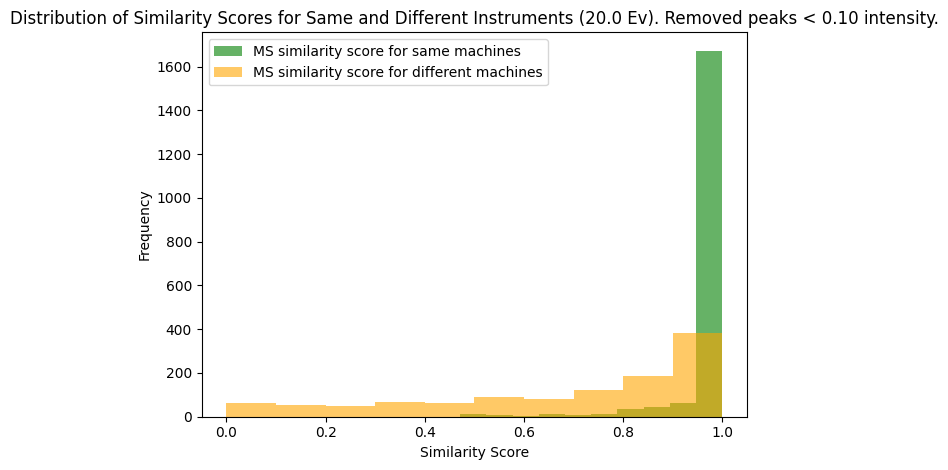

In [61]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_010.items() if len(rec) >= 500] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_010[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_get_mean_score(score)

                    if i == j: 
                        same_instrument_similarity.append(score)
                    else:
                        diff_instrument_similarity.append(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores for Same and Different Instruments ({energy} Ev). Removed peaks < 0.10 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_010.png"), bbox_inches='tight')
    plt.show()

 14%|█▍        | 111/791 [00:00<00:01, 569.20it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 40%|████      | 318/791 [00:00<00:00, 607.17it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 71%|███████▏  | 565/791 [00:00<00:00, 580.86it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 88%|████████▊ | 696/791 [00:01<00:00, 610.59it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 791/791 [00:01<00:00, 620.39it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


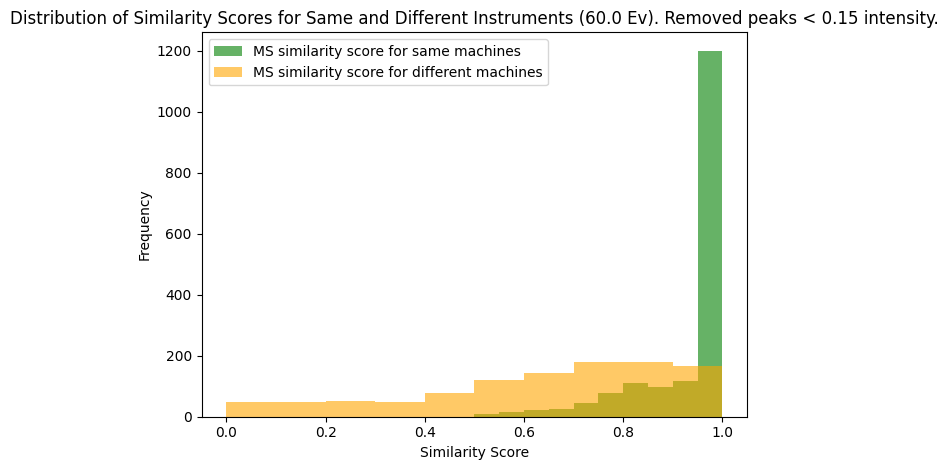

  3%|▎         | 26/776 [00:00<00:02, 253.90it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


  7%|▋         | 52/776 [00:00<00:03, 188.18it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 11%|█▏        | 88/776 [00:00<00:05, 123.79it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 13%|█▎        | 102/776 [00:00<00:06, 98.08it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 17%|█▋        | 135/776 [00:01<00:06, 99.55it/s] 

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 23%|██▎       | 175/776 [00:01<00:04, 137.80it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 28%|██▊       | 214/776 [00:01<00:03, 155.70it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 35%|███▍      | 271/776 [00:01<00:02, 215.29it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 38%|███▊      | 294/776 [00:01<00:02, 190.91it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 46%|████▌     | 354/776 [00:02<00:01, 241.28it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 61%|██████    | 473/776 [00:02<00:00, 319.19it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 74%|███████▎  | 572/776 [00:02<00:00, 503.76it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 80%|████████  | 624/776 [00:02<00:00, 400.76it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 91%|█████████ | 708/776 [00:03<00:00, 337.31it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 776/776 [00:03<00:00, 240.06it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


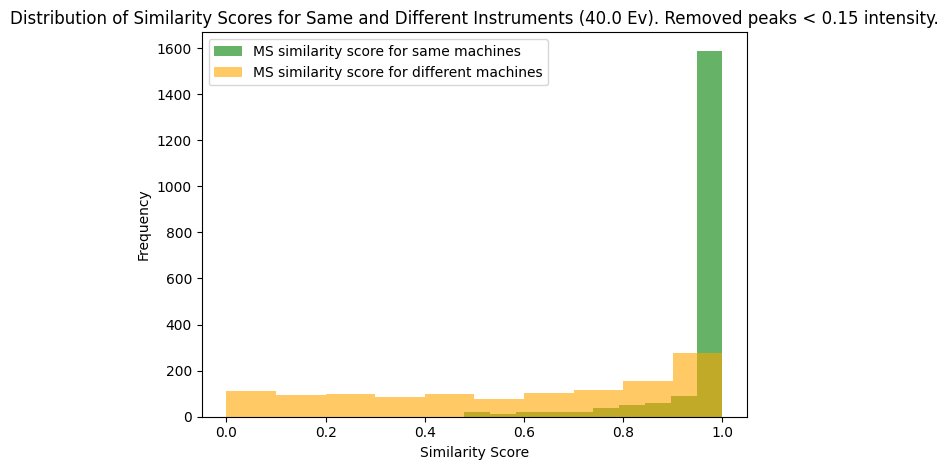

  8%|▊         | 61/774 [00:00<00:02, 297.36it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 12%|█▏        | 91/774 [00:00<00:02, 287.19it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 19%|█▉        | 147/774 [00:00<00:02, 252.21it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 32%|███▏      | 246/774 [00:00<00:01, 302.27it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 43%|████▎     | 335/774 [00:01<00:01, 374.08it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 57%|█████▋    | 442/774 [00:01<00:00, 457.50it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 69%|██████▊   | 531/774 [00:01<00:00, 393.93it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 79%|███████▉  | 612/774 [00:01<00:00, 389.01it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 92%|█████████▏| 712/774 [00:01<00:00, 433.59it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 774/774 [00:02<00:00, 376.42it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


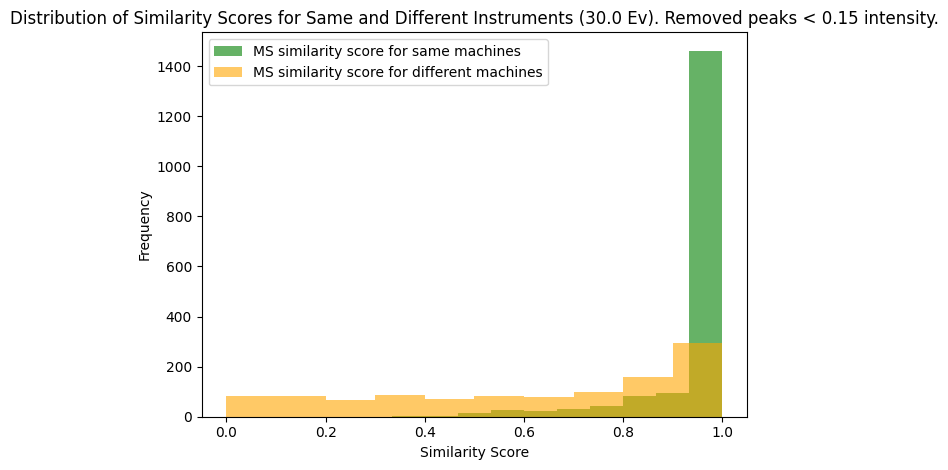

  9%|▉         | 79/833 [00:00<00:01, 402.31it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 22%|██▏       | 180/833 [00:00<00:01, 468.20it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 43%|████▎     | 362/833 [00:00<00:00, 720.58it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

 61%|██████    | 507/833 [00:00<00:00, 671.79it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 83%|████████▎ | 694/833 [00:01<00:00, 797.29it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of intege

100%|██████████| 833/833 [00:01<00:00, 740.60it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


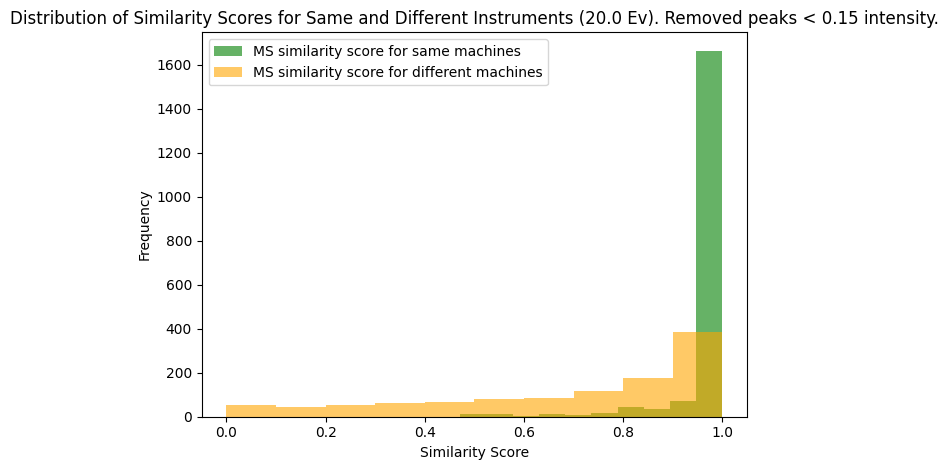

In [62]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_015.items() if len(rec) >= 500] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_015[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_get_mean_score(score)

                    if i == j: 
                        same_instrument_similarity.append(score)
                    else:
                        diff_instrument_similarity.append(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores for Same and Different Instruments ({energy} Ev). Removed peaks < 0.15 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_015.png"), bbox_inches='tight')
    plt.show()